In [48]:
import numpy as np
import mido
import pretty_midi
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import wavio
mpl.rcParams['figure.dpi'] = 600

In [36]:
"""def convert_histograms_into_notes(hist_series, time_difference=1):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(0)
    midi.instruments = [instrument]
    
    instrument.notes = []
    counter = 0
    for hist in hist_series:
        pitch = 21
        for note in hist:
            if note > 0.4:
                note *= 100
                note = int(note // 1)
                midiNote = pretty_midi.Note(note, pitch, counter, counter+time_difference)
                instrument.notes.append(midiNote)
            
            pitch += 1
            
        counter += time_difference
    
    return midi"""

In [74]:
def convert_histograms_into_notes(hist_series, time_difference=1):
    rate = 22050  # samples per second
    T = time_difference
    
    
    out = np.array([])
    
    counter=0
    for hist in hist_series:
        t = np.linspace(counter, counter+T, int(T*rate), endpoint=False)
        pitch = 21
        segment_sum = np.sin(0 * t)
        for note in hist:
            if note > 0:
                f = pretty_midi.note_number_to_hz(pitch)
                x = 2*(note**2)*np.sin(2*np.pi * f * t)
                segment_sum += x
                pitch += 1
        
        out = np.append(out, segment_sum)
        counter += T
    
    return out

In [3]:
class Agent:
    def __init__(self):
        self.pos = np.random.randint(50,76)
        self.remain_at_same = 0
        self.allowed_moves = np.random.randint(0,8,3)
        
    def update(self, hist):
        #interval_weights = [0.6,0.2,0]
        
        desired_index = self.pos - 21
        if self.remain_at_same > hist[desired_index]*8:
            least_weight = 2
            for i in [-12, -9, -8, -7, -5, -4, -3, 3, 4, 5, 7, 8, 9, 12]:
                i += self.pos - 21
                if i >= 0 and i < len(hist):
                    weight = hist[i]
                    if weight < least_weight:
                        desired_index = i
                        least_weight = weight
        elif np.random.random() < 0.1:
            index = self.pos - 21

            desired_index = -1
            best_weight = -1

            for i in range(index-7, index+8):
                if i >= 0 and i < len(hist):
                    #print(i, len(hist), index)
                    weight = hist[i]
                    if weight > best_weight:
                        desired_index = i
                        best_weight = weight
        
        if self.pos == desired_index + 21:
            self.remain_at_same += 1
            #print(self.remain_at_same)
        else:
            #print(self.remain_at_same, "changing")
            self.remain_at_same = 0
        
            move_to_make = np.random.choice(self.allowed_moves)
            if desired_index + 21 > self.pos:
                self.pos += move_to_make
                if self.pos > 108:
                    self.pos = 108
            else:
                self.pos -= move_to_make
                if self.pos < 21:
                    self.pos = 21

In [ ]:
class Pitch:
    def __init__(self, note):
        

In [33]:
class System:
    def __init__(self, number_of_agents):
        
        self.agents = [Agent() for i in range(number_of_agents)]
        self.make_hist()
        
        self.sim_midi = 40
    
    def make_hist(self):
        histogram = np.zeros(109-21)
        for agent in self.agents:
            index = agent.pos - 21
            histogram[index] += 1
        
        
        histogram = histogram/np.max(histogram)
        
        self.hist = histogram
    
    def update(self):
        for agent in self.agents:
            agent.update(self.hist)
        
        self.make_hist()
        
        return self.hist

In [75]:
sy = System(2000)

histogram = [sy.hist]
lengthofmusic = 10
for i in range(lengthofmusic*10):
    histogram.append(sy.update())

sin = convert_histograms_into_notes(histogram, 0.1)

print(len(sin))

wavio.write("histogrampitch.wav", sin, 22050, sampwidth=3)

222705


In [6]:
print(histogram[0])

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.91 0.79 0.75 0.64 0.89 0.67 0.8  0.78 0.72 0.54 0.71 0.87 0.67
 0.67 0.71 0.8  0.85 0.92 0.88 0.73 0.7  0.69 0.73 0.73 1.   0.85 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]


MovieWriter ffmpeg unavailable; using Pillow instead.


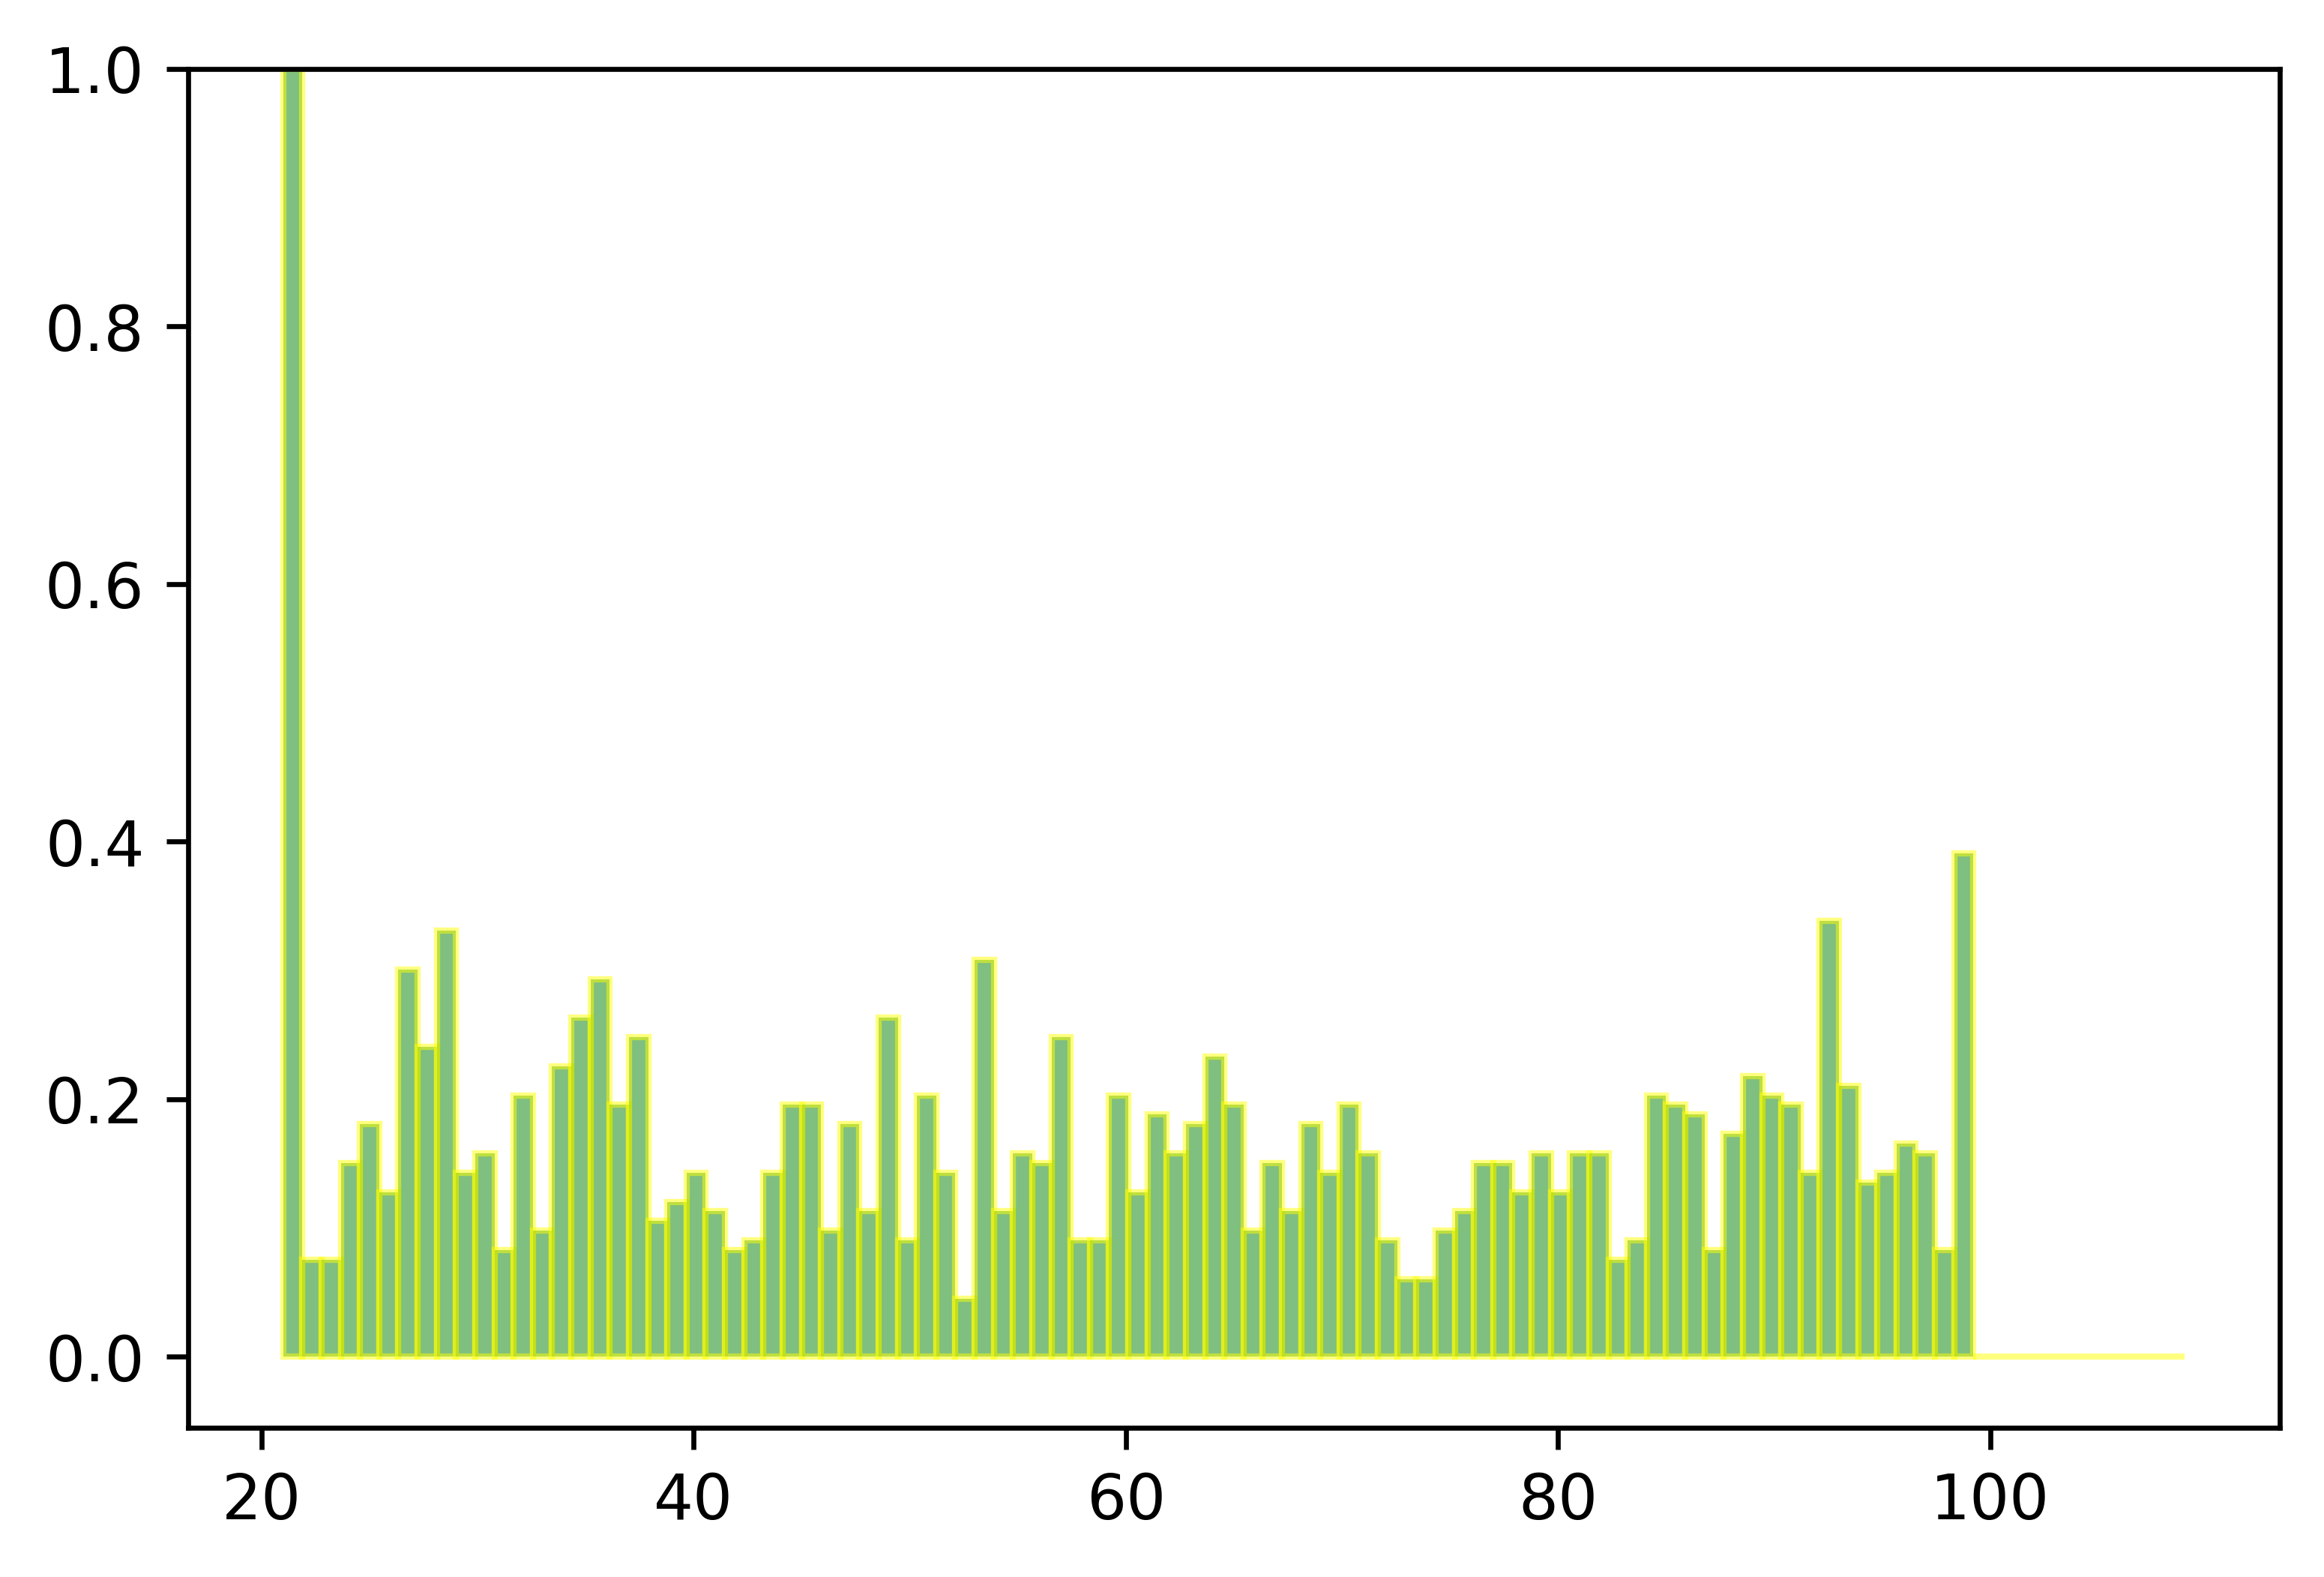

In [76]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)
# Fixing bin edges
HIST_BINS = np.linspace(21, 109, 100)

# histogram our data with numpy
n = histogram[0]
data = histogram[0]
def prepare_animation(bar_container):

    def animate(frame_number):
        n = histogram[frame_number]
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate

fig, ax = plt.subplots()
_, _, bar_container = ax.hist(data, HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5)
ax.set_ylim(top=1)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), len(histogram),
                              repeat=False, blit=True)
ani.save("histogram.gif")